# Blood Cell Classification
### CSCI 494 Deep Learning 

we will  process and load the images, and build  Convolutional Neural Network using keras. 
The evaluation will be done using **SkLearn's Classification Reports, Accuracy/Loss charts and Confusion Matrices.** 


Relevant packages and libraries are imported 

In [1]:
!pip install imutils


  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=72bd994e1a4071eaf9737abb512ded2cbf691a76c7f5f1270ab725dd1faa8c97
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.preprocessing import image
from keras.models import Sequential, Model 
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils


# Object detection:

Finding the specific Cell of interest and cropping 

In [3]:
def findEdges(image):
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged


In [4]:
def getImgContours(edged):
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [5]:
def getBoxes(contours, orig):
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

# Loading Data:

Load_data function that loads images and labels from the Train and Test folders and combines the datasets to return Image-Label pairs 
combining the Train/Test folders and recreate the dataset .

In [6]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (120,120)

In [7]:
def load_data():

    datasets = ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN','/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST' ]
    images = []
    labels = []

    count =0
    for dataset in datasets:

        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                img_path = os.path.join(os.path.join(dataset, folder), file)

                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                edgedImage = findEdges(image1)
                edgedContours = getImgContours(edgedImage)
                edgedBoxes =  getBoxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                image[mask==0] = 0
                
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                image = cv2.resize(image, image_size)

                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [8]:
images, labels = load_data()

100%|██████████| 623/623 [00:07<00:00, 84.43it/s] 


All data (Training and Test combined) is shuffled and split into Training (80%), Validation (10%), Test (10%) sets

In [9]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

# Data Exploration

- How many training, validation and testing examples do we have ? What shape are the images and labels ? 

- What is the proportion of each observed category ? Are the datasets balanced ? 

In [10]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))


Number of training examples: 9716
Number of validation examples: 1215
Number of testing examples: 1215
Training images are of shape: (9716, 120, 120, 3)
Training labels are of shape: (9716,)
Validation images are of shape: (1215, 120, 120, 3)
Validation labels are of shape: (1215,)
Test images are of shape: (1215, 120, 120, 3)
Test labels are of shape: (1215,)


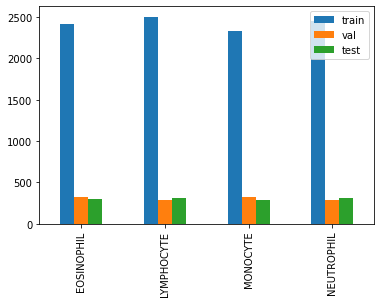

In [11]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

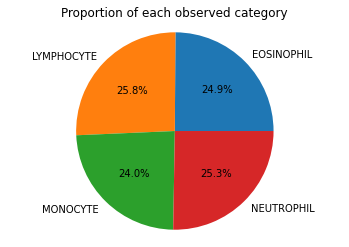

In [12]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

A quick note on preparing the data: Pixel values in RGB images are represented by integers between 0..255. Data is normalised so pixel values are between 0..1 to increase computational speed. 

In [13]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

Another sanity check: Visualise the data by displaying a single random image and 25 random images from the training set with corresponding labels. 


9716


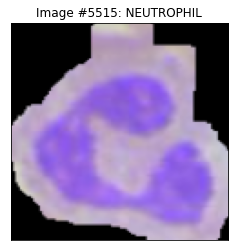

In [14]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

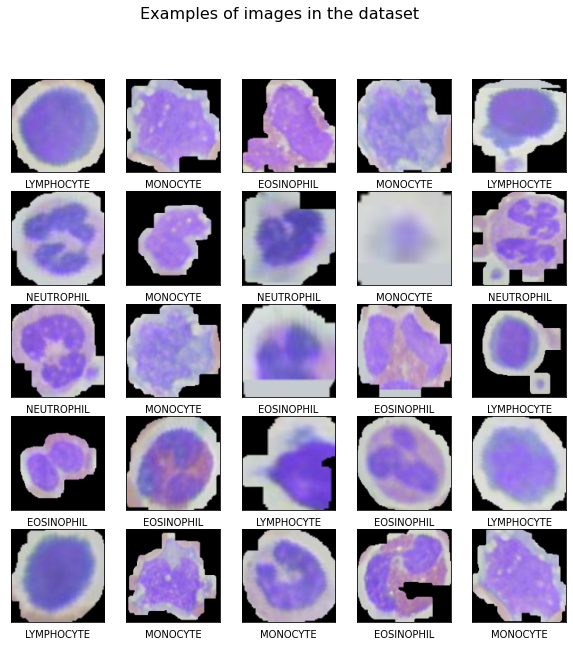

In [15]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

# Custom built CNN

This model contains a sequence of five Conv blocks containing combinations of SeparableConv2D, BatchNormalization, MaxPooling and Dropout layers. The output of the final Conv block is flattened and followed by three Fully Connected (FC) layers each with its own Dropout layer. A final FC layer is added with four units and a softmax activation for multiclass classification. 

In [16]:
model1 = Sequential()

# First Conv block
model1.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv block
model1.add(Conv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Third Conv block
model1.add(Conv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Forth Conv block
model1.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

# Fifth Conv block 
model1.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))


# FC layer 
model1.add(Flatten())
model1.add(Dense(units = 512 , activation = 'elu'))
model1.add(Dropout(0.7))
model1.add(Dense(units = 128 , activation = 'elu'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 64 , activation = 'elu'))
model1.add(Dropout(0.3))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# Train
history1 = model1.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 30, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

2022-11-27 13:32:03.320096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 13:32:03.467902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 13:32:03.469190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 13:32:03.471247: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        2

2022-11-27 13:32:05.862623: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1678924800 exceeds 10% of free system memory.
2022-11-27 13:32:07.696028: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1678924800 exceeds 10% of free system memory.
2022-11-27 13:32:09.040700: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-11-27 13:32:10.820024: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


304/304 [==============================] - 12s 14ms/step - loss: 1.8735 - accuracy: 0.4440 - val_loss: 5.7805 - val_accuracy: 0.2337
Epoch 2/30
304/304 [==============================] - 3s 11ms/step - loss: 0.8207 - accuracy: 0.6862 - val_loss: 0.8841 - val_accuracy: 0.6831
Epoch 3/30
304/304 [==============================] - 3s 11ms/step - loss: 0.5480 - accuracy: 0.7862 - val_loss: 0.3921 - val_accuracy: 0.8477
Epoch 4/30
304/304 [==============================] - 3s 10ms/step - loss: 0.3965 - accuracy: 0.8510 - val_loss: 2.0962 - val_accuracy: 0.4173
Epoch 5/30
304/304 [==============================] - 3s 10ms/step - loss: 0.3314 - accuracy: 0.8790 - val_loss: 0.4728 - val_accuracy: 0.8519
Epoch 6/30
304/304 [==============================] - 3s 11ms/step - loss: 0.2791 - accuracy: 0.8923 - val_loss: 1.7719 - val_accuracy: 0.5128
Epoch 7/30
304/304 [==============================] - 3s 10ms/step - loss: 0.2567 - accuracy: 0.9068 - val_loss: 1.1602 - val_accuracy: 0.7646

Epoch 00

# Evaluating performance

Following model training I emplemented a helper function to plot Accuracy vs Epoch and Loss vs Epoch for both the Training and Validation sets


In [17]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

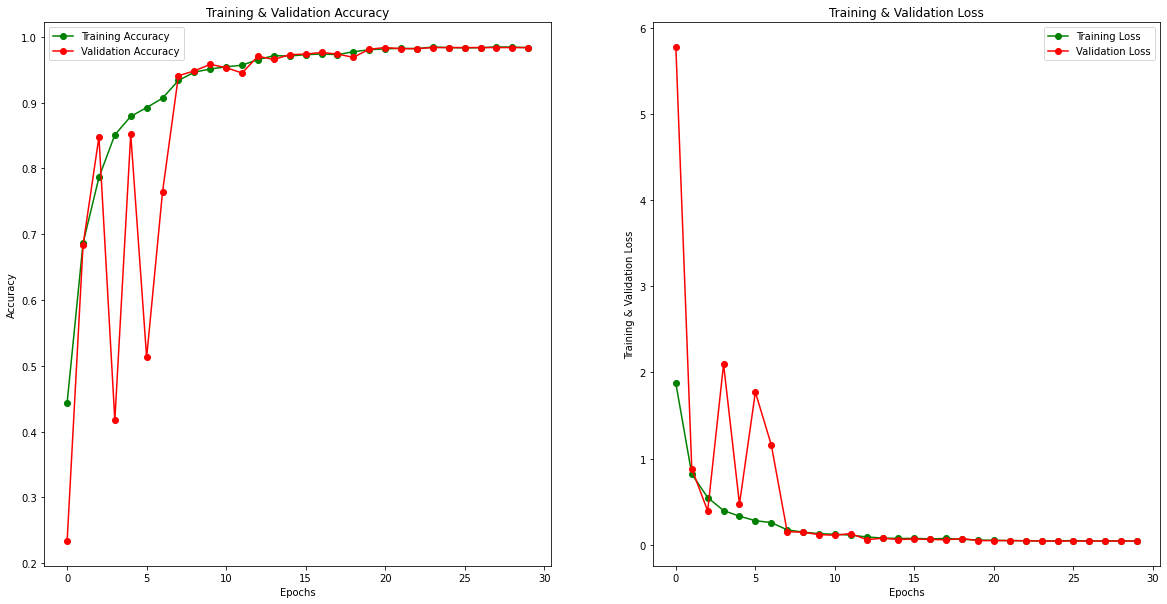

In [18]:
plot_accuracy_loss_chart(history1)

Lets evaluate the model on test data to find the loss and accuracy:


In [19]:

results = model1.evaluate(test_images, test_labels)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model1.evaluate(val_images, val_labels)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")

results = model1.evaluate(train_images, train_labels)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

38/38 [==============================] - 0s 6ms/step - loss: 0.0421 - accuracy: 0.9827
Loss of the model  is - test  0.042097337543964386
Accuracy of the model is - test 98.27160239219666 %
38/38 [==============================] - 0s 6ms/step - loss: 0.0432 - accuracy: 0.9835
Loss of the model  is - val  0.04324013739824295
Accuracy of the model is - val 98.35391044616699 %


2022-11-27 13:34:03.603640: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1678924800 exceeds 10% of free system memory.
2022-11-27 13:34:05.748431: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1678924800 exceeds 10% of free system memory.


304/304 [==============================] - 2s 5ms/step - loss: 0.0175 - accuracy: 0.9933
Loss of the model  is - train  0.017510756850242615
Accuracy of the model is - train 99.33099746704102 %


Model (and weights) are saved after training. The best model and its weights can also be saved using the ModelCheckpoint callback if "EarlyStopping" is activated in the Model.fit phase. [More on this here](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

I decided against using EarlyStopping, but I will try to include it in future work on this dataset. 

In [20]:
model1.save('Bloodcell_Classification_Model1_Custom_Build_10_epochs.h5')

In [21]:
from sklearn.metrics import classification_report

predictions = model1.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([2, 0, 3, 1, 0, 2, 2, 3, 0, 3, 2, 0, 1, 3, 1])

In [22]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.95      0.98      0.97       301
LYMPHOCYTE (Class 1)       1.00      0.99      1.00       314
  MONOCYTE (Class 2)       0.99      1.00      1.00       282
NEUTROPHIL (Class 3)       0.98      0.96      0.97       318

            accuracy                           0.98      1215
           macro avg       0.98      0.98      0.98      1215
        weighted avg       0.98      0.98      0.98      1215



A second helper function is created to plot confusion matrix. which will give us a better visualization of these results. 

In [23]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,296,0,1,4
1,1,312,0,1
2,0,0,282,0
3,13,0,1,304


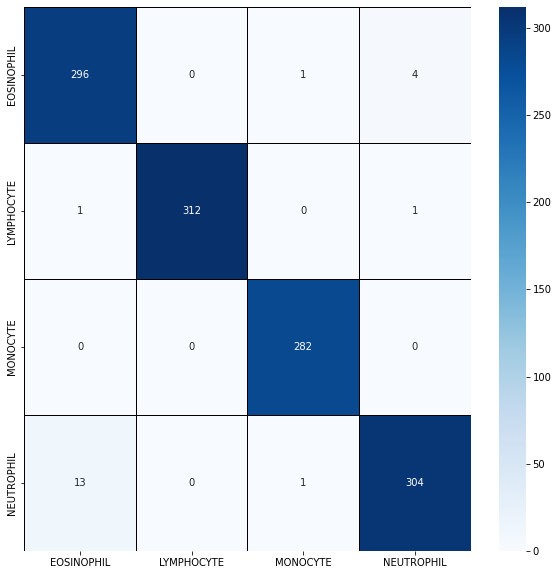

In [24]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

# Predictions (Demo)


In [25]:
def plot_image(i, predictions_array, true_label, img):
    
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(4))
    plt.yticks([])
    thisplot = plt.bar(range(4), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [26]:
test_labels[:10]

array([0, 0, 3, 1, 0, 2, 2, 3, 0, 3], dtype=int32)

In [27]:
predictions = model1.predict(test_images)
print(predictions[:10])


[[2.7324668e-01 1.3091800e-01 3.2993257e-01 2.6590273e-01]
 [9.9999440e-01 2.0363160e-14 6.0778321e-14 5.5680916e-06]
 [1.1367024e-03 5.4770183e-08 9.1254224e-05 9.9877197e-01]
 [5.6768756e-12 9.9999321e-01 6.7619790e-06 7.1072456e-13]
 [9.9349833e-01 6.4966969e-08 4.9347875e-08 6.5014954e-03]
 [7.1916960e-15 2.7769690e-12 1.0000000e+00 7.5137531e-15]
 [1.1679508e-11 1.7817565e-09 1.0000000e+00 2.0242917e-10]
 [2.2860377e-12 1.1883242e-27 7.9529472e-17 1.0000000e+00]
 [9.9998963e-01 6.6923077e-14 1.3074417e-13 1.0321316e-05]
 [1.3611893e-12 1.3465272e-27 2.6790881e-17 1.0000000e+00]]


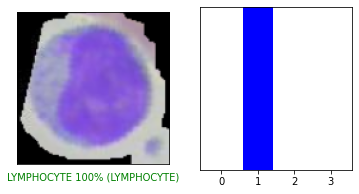

In [28]:
i = tf.random.uniform(shape=(), minval=0, maxval=len(test_labels), dtype=tf.int32)

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

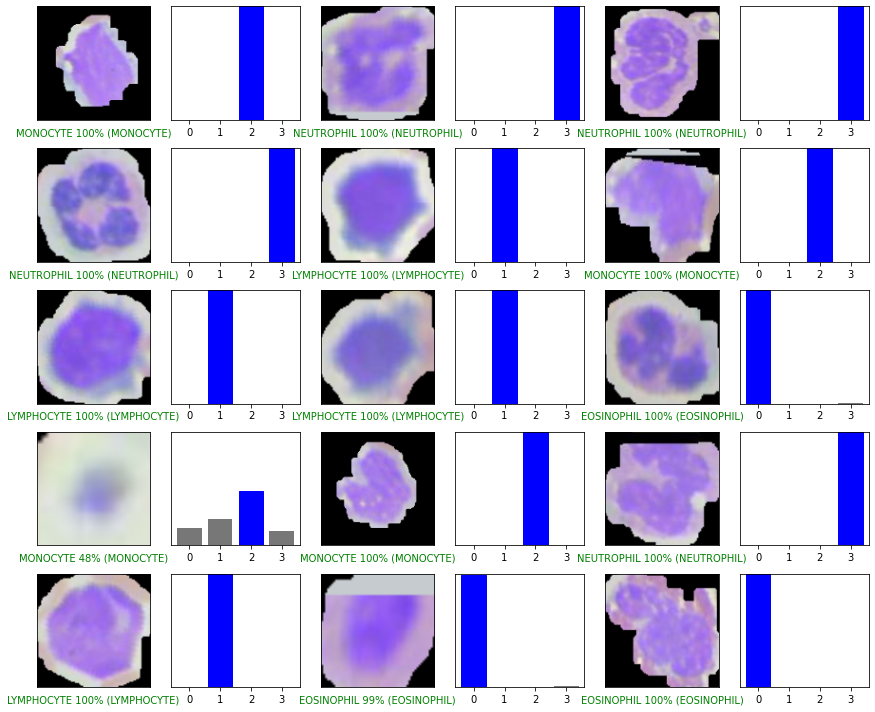

In [29]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    x = tf.random.uniform(shape=(), minval=0, maxval=len(test_labels), dtype=tf.int32)

    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(x, predictions[x], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(x, predictions[x], test_labels)
plt.tight_layout()
plt.show()

In [30]:
def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [31]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 64)        2

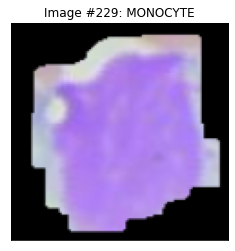

In [58]:
index = np.random.randint(test_images.shape[0])
plt.figure()
plt.imshow(test_images[index])
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title('Image #{}: '.format(index) + class_names[test_labels[index]])
plt.show()

In [60]:
img = tf.keras.preprocessing.image.array_to_img(test_images[index])
img_path = "test_monocyte.jpg"
img.save(img_path)

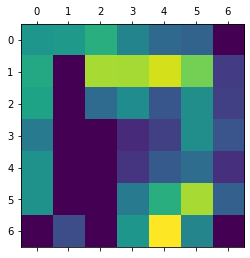

In [61]:
last_conv_layer_name = "conv2d_4"

preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

array = keras.preprocessing.image.img_to_array(test_images[index])
array = np.expand_dims(array, axis=0)

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=image_size))

# Remove last layer's softmax
model1.layers[-1].activation = None

# Print what the top predicted class is
# preds = model1.predict(test_images[index])
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model1, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

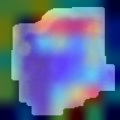

In [62]:
from IPython.display import Image, display
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)
    
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(superimposed_img)
    
save_and_display_gradcam(img_path, heatmap)